In [2]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
# Dataset folders 
dataset_dir = 'atMost400'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

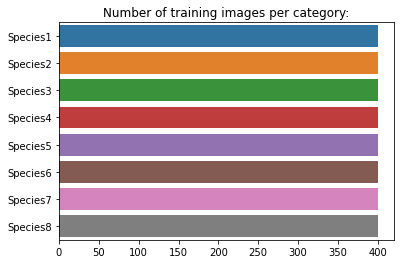

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [11]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 3200 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [12]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 1. 0. 0.]
Label: 5
Class name: Species6


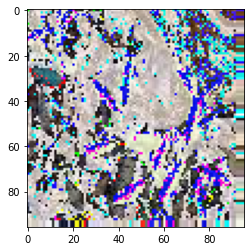

In [13]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [14]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

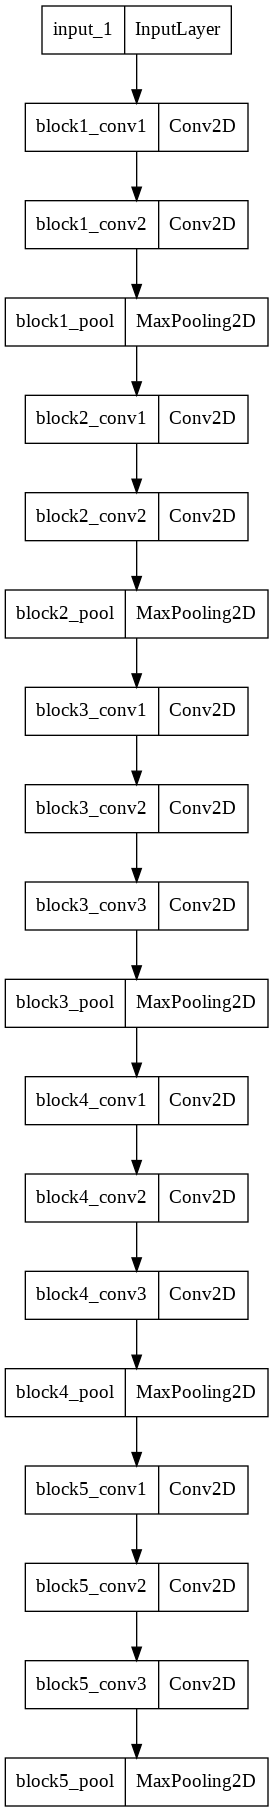

In [15]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [16]:
input_shape = (96, 96, 3)
epochs = 200

In [17]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [18]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [19]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 3.9828 - accuracy: 0.3584 - precision: 0.3904 - recall: 0.2928

100/100 [==============================] - 29s 206ms/step - loss: 3.9828 - accuracy: 0.3584 - precision: 0.3904 - recall: 0.2928 - val_loss: 1.4718 - val_accuracy: 0.4516 - val_precision: 0.6897 - val_recall: 0.1898
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 1.6137 - accuracy: 0.4541 - precision: 0.6037 - recall: 0.3038

100/100 [==============================] - 19s 189ms/step - loss: 1.6137 - accuracy: 0.4541 - precision: 0.6037 - recall: 0.3038 - val_loss: 1.3083 - val_accuracy: 0.4915 - val_precision: 0.7020 - val_recall: 0.2638
Epoch 3/200
100/100 [==============================] - ETA: 0s - loss: 1.4043 - accuracy: 0.5106 - precision: 0.6329 - recall: 0.3534

100/100 [==============================] - 20s 196ms/step - loss: 1.4043 - accuracy: 0.5106 - precision: 0.6329 - recall: 0.3534 - val_loss: 1.2142 - val_accuracy: 0.5465 - val_precision: 0.7623 - val_recall: 0.3529
Epoch 4/200
100/100 [==============================] - ETA: 0s - loss: 1.2629 - accuracy: 0.5422 - precision: 0.6705 - recall: 0.4050

100/100 [==============================] - 20s 198ms/step - loss: 1.2629 - accuracy: 0.5422 - precision: 0.6705 - recall: 0.4050 - val_loss: 1.1706 - val_accuracy: 0.5446 - val_precision: 0.7343 - val_recall: 0.3985
Epoch 5/200
100/100 [==============================] - ETA: 0s - loss: 1.2072 - accuracy: 0.5766 - precision: 0.7052 - recall: 0.4494

100/100 [==============================] - 19s 189ms/step - loss: 1.2072 - accuracy: 0.5766 - precision: 0.7052 - recall: 0.4494 - val_loss: 1.1171 - val_accuracy: 0.5617 - val_precision: 0.7437 - val_recall: 0.3909
Epoch 6/200
100/100 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.5706 - precision: 0.6890 - recall: 0.4369

100/100 [==============================] - 19s 189ms/step - loss: 1.1773 - accuracy: 0.5706 - precision: 0.6890 - recall: 0.4369 - val_loss: 1.0531 - val_accuracy: 0.5901 - val_precision: 0.7690 - val_recall: 0.4421
Epoch 7/200
100/100 [==============================] - ETA: 0s - loss: 1.1206 - accuracy: 0.5947 - precision: 0.7132 - recall: 0.4678

100/100 [==============================] - 20s 198ms/step - loss: 1.1206 - accuracy: 0.5947 - precision: 0.7132 - recall: 0.4678 - val_loss: 1.1008 - val_accuracy: 0.5731 - val_precision: 0.7293 - val_recall: 0.4345
Epoch 8/200
100/100 [==============================] - ETA: 0s - loss: 1.1189 - accuracy: 0.5922 - precision: 0.7160 - recall: 0.4734

100/100 [==============================] - 18s 184ms/step - loss: 1.1189 - accuracy: 0.5922 - precision: 0.7160 - recall: 0.4734 - val_loss: 1.0917 - val_accuracy: 0.5806 - val_precision: 0.7134 - val_recall: 0.4250
Epoch 9/200
100/100 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.6147 - precision: 0.7334 - recall: 0.4875

100/100 [==============================] - 19s 189ms/step - loss: 1.0732 - accuracy: 0.6147 - precision: 0.7334 - recall: 0.4875 - val_loss: 1.0455 - val_accuracy: 0.5825 - val_precision: 0.7370 - val_recall: 0.4307
Epoch 10/200
100/100 [==============================] - ETA: 0s - loss: 1.0485 - accuracy: 0.6112 - precision: 0.7107 - recall: 0.4913

100/100 [==============================] - 20s 200ms/step - loss: 1.0485 - accuracy: 0.6112 - precision: 0.7107 - recall: 0.4913 - val_loss: 1.0090 - val_accuracy: 0.6300 - val_precision: 0.7353 - val_recall: 0.4744
Epoch 11/200
100/100 [==============================] - ETA: 0s - loss: 1.0095 - accuracy: 0.6297 - precision: 0.7388 - recall: 0.5056

100/100 [==============================] - 19s 190ms/step - loss: 1.0095 - accuracy: 0.6297 - precision: 0.7388 - recall: 0.5056 - val_loss: 0.9904 - val_accuracy: 0.6319 - val_precision: 0.7537 - val_recall: 0.4820
Epoch 12/200
100/100 [==============================] - ETA: 0s - loss: 0.9784 - accuracy: 0.6488 - precision: 0.7499 - recall: 0.5331

100/100 [==============================] - 19s 187ms/step - loss: 0.9784 - accuracy: 0.6488 - precision: 0.7499 - recall: 0.5331 - val_loss: 0.9891 - val_accuracy: 0.6072 - val_precision: 0.7662 - val_recall: 0.4725
Epoch 13/200
100/100 [==============================] - ETA: 0s - loss: 0.9654 - accuracy: 0.6556 - precision: 0.7594 - recall: 0.5425

100/100 [==============================] - 20s 201ms/step - loss: 0.9654 - accuracy: 0.6556 - precision: 0.7594 - recall: 0.5425 - val_loss: 1.0148 - val_accuracy: 0.6243 - val_precision: 0.7508 - val_recall: 0.4573
Epoch 14/200
100/100 [==============================] - ETA: 0s - loss: 0.9657 - accuracy: 0.6516 - precision: 0.7641 - recall: 0.5425

100/100 [==============================] - 19s 186ms/step - loss: 0.9657 - accuracy: 0.6516 - precision: 0.7641 - recall: 0.5425 - val_loss: 0.9771 - val_accuracy: 0.6338 - val_precision: 0.7500 - val_recall: 0.5237
Epoch 15/200
100/100 [==============================] - ETA: 0s - loss: 0.9210 - accuracy: 0.6656 - precision: 0.7573 - recall: 0.5578

100/100 [==============================] - 19s 188ms/step - loss: 0.9210 - accuracy: 0.6656 - precision: 0.7573 - recall: 0.5578 - val_loss: 0.9565 - val_accuracy: 0.6509 - val_precision: 0.7623 - val_recall: 0.5294
Epoch 16/200
100/100 [==============================] - ETA: 0s - loss: 0.9310 - accuracy: 0.6706 - precision: 0.7701 - recall: 0.5725

100/100 [==============================] - 19s 191ms/step - loss: 0.9310 - accuracy: 0.6706 - precision: 0.7701 - recall: 0.5725 - val_loss: 0.9918 - val_accuracy: 0.6129 - val_precision: 0.7236 - val_recall: 0.5066
Epoch 17/200
100/100 [==============================] - ETA: 0s - loss: 0.9377 - accuracy: 0.6619 - precision: 0.7610 - recall: 0.5544

100/100 [==============================] - 19s 187ms/step - loss: 0.9377 - accuracy: 0.6619 - precision: 0.7610 - recall: 0.5544 - val_loss: 1.0135 - val_accuracy: 0.6091 - val_precision: 0.7364 - val_recall: 0.4877
Epoch 18/200
100/100 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.6775 - precision: 0.7733 - recall: 0.5747

100/100 [==============================] - 18s 185ms/step - loss: 0.8923 - accuracy: 0.6775 - precision: 0.7733 - recall: 0.5747 - val_loss: 0.9749 - val_accuracy: 0.6565 - val_precision: 0.7592 - val_recall: 0.5085
Epoch 19/200
100/100 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.6816 - precision: 0.7751 - recall: 0.5816

100/100 [==============================] - 19s 193ms/step - loss: 0.8759 - accuracy: 0.6816 - precision: 0.7751 - recall: 0.5816 - val_loss: 0.9422 - val_accuracy: 0.6509 - val_precision: 0.7556 - val_recall: 0.5161
Epoch 20/200
100/100 [==============================] - ETA: 0s - loss: 0.8663 - accuracy: 0.6972 - precision: 0.7840 - recall: 0.6022

100/100 [==============================] - 18s 185ms/step - loss: 0.8663 - accuracy: 0.6972 - precision: 0.7840 - recall: 0.6022 - val_loss: 0.9341 - val_accuracy: 0.6584 - val_precision: 0.7565 - val_recall: 0.5484
Epoch 21/200
100/100 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6819 - precision: 0.7678 - recall: 0.5766

100/100 [==============================] - 19s 189ms/step - loss: 0.8781 - accuracy: 0.6819 - precision: 0.7678 - recall: 0.5766 - val_loss: 0.9277 - val_accuracy: 0.6546 - val_precision: 0.7568 - val_recall: 0.5313
Epoch 22/200
100/100 [==============================] - ETA: 0s - loss: 0.8691 - accuracy: 0.6803 - precision: 0.7773 - recall: 0.5922

100/100 [==============================] - 19s 185ms/step - loss: 0.8691 - accuracy: 0.6803 - precision: 0.7773 - recall: 0.5922 - val_loss: 0.9538 - val_accuracy: 0.6414 - val_precision: 0.7778 - val_recall: 0.4915
Epoch 23/200
100/100 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.6888 - precision: 0.7785 - recall: 0.6019

100/100 [==============================] - 19s 192ms/step - loss: 0.8420 - accuracy: 0.6888 - precision: 0.7785 - recall: 0.6019 - val_loss: 0.9368 - val_accuracy: 0.6509 - val_precision: 0.7527 - val_recall: 0.5370
Epoch 24/200
100/100 [==============================] - ETA: 0s - loss: 0.8718 - accuracy: 0.6928 - precision: 0.7874 - recall: 0.5856

100/100 [==============================] - 18s 184ms/step - loss: 0.8718 - accuracy: 0.6928 - precision: 0.7874 - recall: 0.5856 - val_loss: 0.9931 - val_accuracy: 0.6433 - val_precision: 0.7486 - val_recall: 0.5085
Epoch 25/200
100/100 [==============================] - ETA: 0s - loss: 0.8280 - accuracy: 0.6894 - precision: 0.7897 - recall: 0.6091

100/100 [==============================] - 19s 185ms/step - loss: 0.8280 - accuracy: 0.6894 - precision: 0.7897 - recall: 0.6091 - val_loss: 0.9523 - val_accuracy: 0.6319 - val_precision: 0.7614 - val_recall: 0.5085
Epoch 26/200
100/100 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.7031 - precision: 0.7963 - recall: 0.6109

100/100 [==============================] - 19s 194ms/step - loss: 0.8233 - accuracy: 0.7031 - precision: 0.7963 - recall: 0.6109 - val_loss: 1.0362 - val_accuracy: 0.6186 - val_precision: 0.7420 - val_recall: 0.5294
Epoch 27/200
100/100 [==============================] - ETA: 0s - loss: 0.8246 - accuracy: 0.7091 - precision: 0.7910 - recall: 0.6150

100/100 [==============================] - 19s 187ms/step - loss: 0.8246 - accuracy: 0.7091 - precision: 0.7910 - recall: 0.6150 - val_loss: 0.9906 - val_accuracy: 0.6357 - val_precision: 0.7243 - val_recall: 0.5484
Epoch 28/200
100/100 [==============================] - ETA: 0s - loss: 0.8304 - accuracy: 0.7022 - precision: 0.7917 - recall: 0.6069

100/100 [==============================] - 18s 184ms/step - loss: 0.8304 - accuracy: 0.7022 - precision: 0.7917 - recall: 0.6069 - val_loss: 0.9664 - val_accuracy: 0.6414 - val_precision: 0.7487 - val_recall: 0.5484
Epoch 29/200
100/100 [==============================] - ETA: 0s - loss: 0.7929 - accuracy: 0.7122 - precision: 0.7951 - recall: 0.6319

100/100 [==============================] - 19s 194ms/step - loss: 0.7929 - accuracy: 0.7122 - precision: 0.7951 - recall: 0.6319 - val_loss: 0.9060 - val_accuracy: 0.6736 - val_precision: 0.7688 - val_recall: 0.5806
Epoch 30/200
100/100 [==============================] - ETA: 0s - loss: 0.7937 - accuracy: 0.7206 - precision: 0.8013 - recall: 0.6338

100/100 [==============================] - 20s 198ms/step - loss: 0.7937 - accuracy: 0.7206 - precision: 0.8013 - recall: 0.6338 - val_loss: 0.9467 - val_accuracy: 0.6584 - val_precision: 0.7474 - val_recall: 0.5560
Epoch 31/200
100/100 [==============================] - ETA: 0s - loss: 0.8008 - accuracy: 0.7206 - precision: 0.8026 - recall: 0.6291

100/100 [==============================] - 18s 182ms/step - loss: 0.8008 - accuracy: 0.7206 - precision: 0.8026 - recall: 0.6291 - val_loss: 0.9280 - val_accuracy: 0.6565 - val_precision: 0.7540 - val_recall: 0.5408
Epoch 32/200
100/100 [==============================] - ETA: 0s - loss: 0.7806 - accuracy: 0.7206 - precision: 0.7931 - recall: 0.6350

100/100 [==============================] - 20s 196ms/step - loss: 0.7806 - accuracy: 0.7206 - precision: 0.7931 - recall: 0.6350 - val_loss: 0.9241 - val_accuracy: 0.6774 - val_precision: 0.7702 - val_recall: 0.5598
Epoch 33/200
100/100 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.7159 - precision: 0.8047 - recall: 0.6359

100/100 [==============================] - 19s 185ms/step - loss: 0.7944 - accuracy: 0.7159 - precision: 0.8047 - recall: 0.6359 - val_loss: 0.9781 - val_accuracy: 0.6414 - val_precision: 0.7554 - val_recall: 0.5275
Epoch 34/200
100/100 [==============================] - ETA: 0s - loss: 0.7718 - accuracy: 0.7225 - precision: 0.7994 - recall: 0.6363

100/100 [==============================] - 18s 185ms/step - loss: 0.7718 - accuracy: 0.7225 - precision: 0.7994 - recall: 0.6363 - val_loss: 0.9425 - val_accuracy: 0.6755 - val_precision: 0.7481 - val_recall: 0.5465
Epoch 35/200
100/100 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.7303 - precision: 0.8043 - recall: 0.6475

100/100 [==============================] - 19s 195ms/step - loss: 0.7529 - accuracy: 0.7303 - precision: 0.8043 - recall: 0.6475 - val_loss: 0.9383 - val_accuracy: 0.6755 - val_precision: 0.7816 - val_recall: 0.5636
Epoch 36/200
100/100 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.7281 - precision: 0.7985 - recall: 0.6453

100/100 [==============================] - 18s 185ms/step - loss: 0.7530 - accuracy: 0.7281 - precision: 0.7985 - recall: 0.6453 - val_loss: 0.9528 - val_accuracy: 0.6546 - val_precision: 0.7494 - val_recall: 0.5560
Epoch 37/200
100/100 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.7222 - precision: 0.7987 - recall: 0.6484

100/100 [==============================] - 19s 190ms/step - loss: 0.7669 - accuracy: 0.7222 - precision: 0.7987 - recall: 0.6484 - val_loss: 0.9070 - val_accuracy: 0.6698 - val_precision: 0.7644 - val_recall: 0.5541
Epoch 38/200
100/100 [==============================] - ETA: 0s - loss: 0.7872 - accuracy: 0.7144 - precision: 0.8026 - recall: 0.6444

100/100 [==============================] - 19s 192ms/step - loss: 0.7872 - accuracy: 0.7144 - precision: 0.8026 - recall: 0.6444 - val_loss: 1.0464 - val_accuracy: 0.6319 - val_precision: 0.7194 - val_recall: 0.5351
Epoch 39/200
100/100 [==============================] - ETA: 0s - loss: 0.7568 - accuracy: 0.7191 - precision: 0.8005 - recall: 0.6356

100/100 [==============================] - 19s 188ms/step - loss: 0.7568 - accuracy: 0.7191 - precision: 0.8005 - recall: 0.6356 - val_loss: 0.9617 - val_accuracy: 0.6509 - val_precision: 0.7383 - val_recall: 0.5674
Epoch 40/200
100/100 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.7325 - precision: 0.8016 - recall: 0.6438

100/100 [==============================] - 18s 184ms/step - loss: 0.7569 - accuracy: 0.7325 - precision: 0.8016 - recall: 0.6438 - val_loss: 0.9483 - val_accuracy: 0.6679 - val_precision: 0.7833 - val_recall: 0.5693
Epoch 41/200
100/100 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.7353 - precision: 0.8100 - recall: 0.6609

100/100 [==============================] - 20s 202ms/step - loss: 0.7265 - accuracy: 0.7353 - precision: 0.8100 - recall: 0.6609 - val_loss: 0.9438 - val_accuracy: 0.6717 - val_precision: 0.7625 - val_recall: 0.5787
Epoch 42/200
100/100 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7219 - precision: 0.8053 - recall: 0.6500

100/100 [==============================] - 18s 185ms/step - loss: 0.7574 - accuracy: 0.7219 - precision: 0.8053 - recall: 0.6500 - val_loss: 0.9447 - val_accuracy: 0.6755 - val_precision: 0.7634 - val_recall: 0.5693


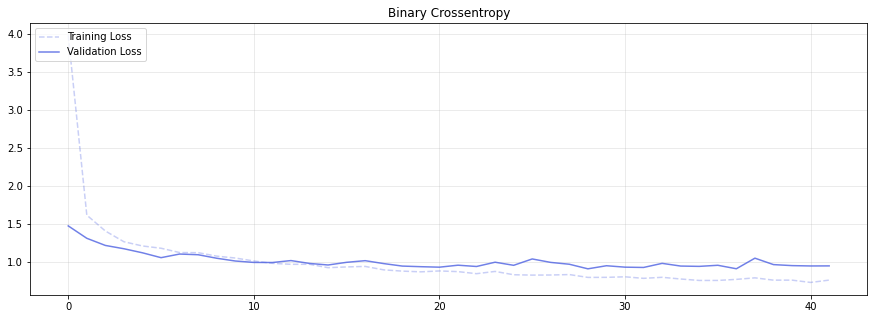

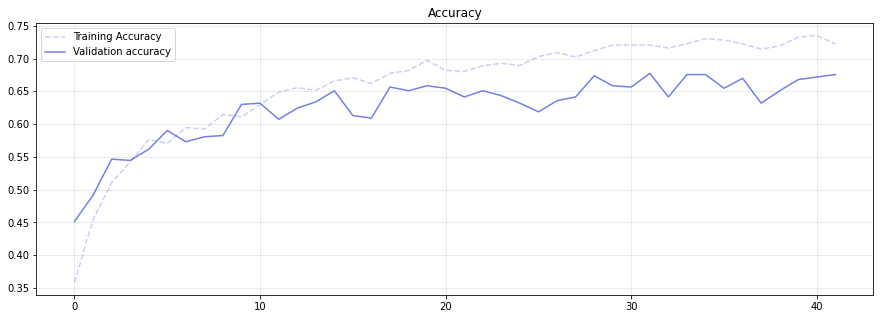

In [20]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [21]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [22]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [23]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [24]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [25]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [26]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
100/100 [==============================] - 16s 140ms/step - loss: 1.1340 - accuracy: 0.6125 - precision_1: 0.7184 - recall_1: 0.5063 - val_loss: 0.9680 - val_accuracy: 0.6433 - val_precision_1: 0.7674 - val_recall_1: 0.4820
Epoch 2/200
100/100 [==============================] - 13s 134ms/step - loss: 0.9321 - accuracy: 0.6756 - precision_1: 0.7657 - recall_1: 0.5750 - val_loss: 0.8724 - val_accuracy: 0.7078 - val_precision_1: 0.7775 - val_recall_1: 0.6167
Epoch 3/200
100/100 [==============================] - 14s 135ms/step - loss: 0.8583 - accuracy: 0.7053 - precision_1: 0.7884 - recall_1: 0.6091 - val_loss: 0.8959 - val_accuracy: 0.6736 - val_precision_1: 0.7800 - val_recall_1: 0.6053
Epoch 4/200
100/100 [==============================] - 14s 141ms/step - loss: 0.7768 - accuracy: 0.7256 - precision_1: 0.8086 - recall_1: 0.6363 - val_loss: 0.8661 - val_accuracy: 0.6850 - val_precision_1: 0.7676 - val_recall_1: 0.6015
Epoch 5/200
100/100 [==============================] - 1

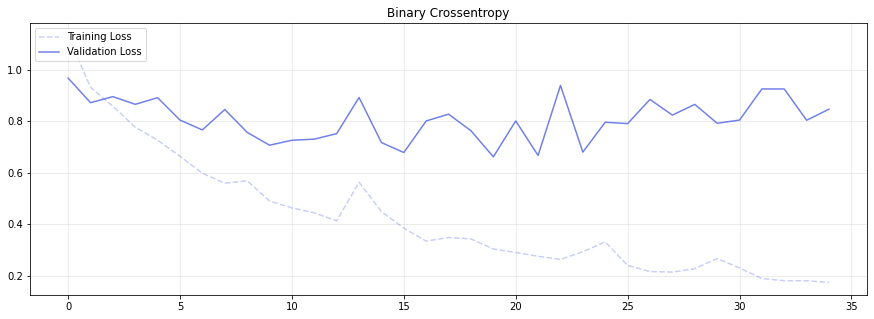

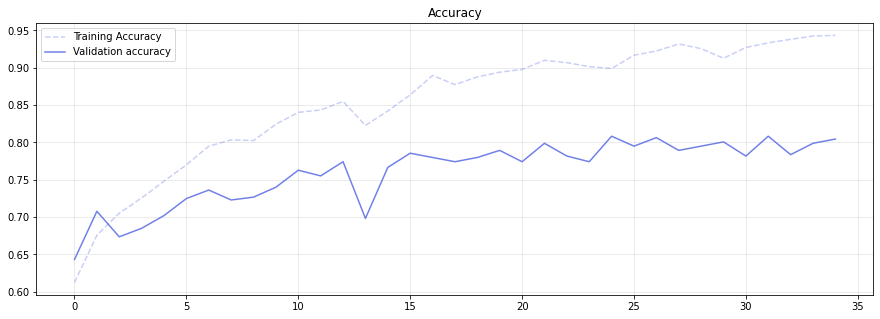

In [27]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [28]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [29]:
tl_model.save('Vgg16/Tuned_v1_1')

In [30]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 1s 94ms/step - loss: 0.7014 - accuracy: 0.7839 - precision_1: 0.8065 - recall_1: 0.7618

Test metrics
{'loss': 0.701380729675293, 'accuracy': 0.7839335203170776, 'precision_1': 0.8064516186714172, 'recall_1': 0.761772871017456}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7839
Precision: 0.7724
Recall: 0.7653
F1: 0.7671


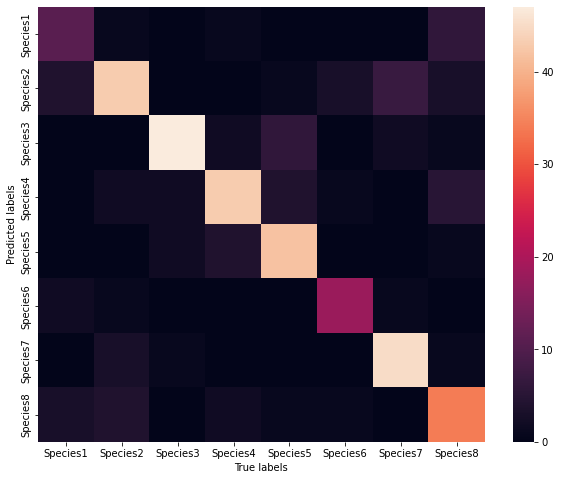

In [31]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()